In [ ]:
import Pkg; Pkg.activate("C:/Users/a7b/Pico.jl"); Pkg.instantiate()

In [ ]:
using Pico
using PyPlot
using QuantumOptics
using ForwardDiff
using Interpolations
using LinearAlgebra
using SparseArrays
using OSQP

In [ ]:
WDIR = joinpath(@__DIR__, "../../")
include(joinpath(WDIR, "experiments", "ilqoc", "measurement.jl"))

In [ ]:
#set up the 2 level transmon system

iter = 3000
ω = 2π * 4.96 #GHz
α = -2π * 0.143 #GHz
levels = 2

ψg = [1. + 0*im, 0]
ψe = [0, 1. + 0*im]

ψ1 = [ψg, ψe]
ψf = [-im*ψe, -im*ψg]

H_drift = α/2 * Pico.quad(levels)
H_drive = [Pico.create(levels) + Pico.annihilate(levels),
1im * (Pico.create(levels) - Pico.annihilate(levels))]

sys = QuantumSystem(
    H_drift, 
    H_drive,
    ψ1 = ψ1,
    ψf = ψf,
    control_bounds = [2π * 19e-3,  2π * 19e-3]
);

In [ ]:
# Define the optimal control problem.
# Here we are doing a pi pulse (Rx(pi) gate).
T = 400
Δt = 0.1
Q = 200.
R = 0.1
cost = infidelity_cost
hess = true
pinqstate = true

time = T * Δt

options = Options(
    max_iter = iter,
    tol = 1e-5
)

prob = QuantumControlProblem(
    sys,
    T;
    Δt = Δt,
    Q = Q,
    R = R,
    eval_hessian = hess,
    cost = cost,
    pin_first_qstate = pinqstate,
    options = options
);

In [ ]:
# This will give us the nominal trajectory that we need to track
solve!(prob)

In [ ]:
#Extract the solution
Xopt = prob.trajectory.states
Uopt = prob.trajectory.actions 

display(Xopt)
display(Uopt)

#Add the measurements we care about to the state vector.
#Here they are the Pauli measurements <σ_x>, <σ_y>, <σ_z>
for i = 1:length(Xopt)
    x = Xopt[i]
    meas = zeros(0)
    for s = 1:sys.nqstates
        iso_state = x[slice(s, sys.isodim)]
        append!(meas, meas_x_iso(iso_state))
        append!(meas, meas_y_iso(iso_state))
        append!(meas, meas_z_iso(iso_state))
    end
    Xopt[i] = [x[1:sys.n_wfn_states]; meas; x[(sys.n_wfn_states + 1):end]]
end


In [8]:
#Set up xnom, unom, and utraj

n = sys.nstates + 3*sys.nqstates
print(n)
m = sys.ncontrols

xnom = zeros(n, prob.T)

for k = 1:prob.T
    xnom[:, k] .= Xopt[k]
end

unom = zeros(m, prob.T - 1)
utraj = zeros(m, prob.T - 1)

for k = 1:prob.T - 1
    unom[:, k] .= Uopt[k]
    utraj[:, k] .= Uopt[k]
end

display(xnom)
display(Xopt)

18

In [9]:
#Nominal model for the system
function discrete_dynamics(x, u)
    G = sys.G_drift + x[15] * sys.G_drives[1] + x[16] * sys.G_drives[2]
    h_prop = exp(G * Δt)
    state1_ = x[1:4]
    state2_ = x[5:8]
    state1 = h_prop * state1_
    state2 = h_prop * state2_
    meas_1 = [meas_x_iso(state1), meas_y_iso(state1), meas_z_iso(state1)]
    meas_2 = [meas_x_iso(state2), meas_y_iso(state2), meas_z_iso(state2)]
    controls = x[15:16] + x[17:18] .* Δt
    dcontrols = x[17:18] + u[1:2] .* Δt
    return [state1; state2; meas_1; meas_2; controls; dcontrols]
end

#Fake true model for the system. Just add a small sigmaz() term to the Hamiltonian
function true_dynamics(x, u)
    G = sys.G_drift + 0.01*get_mat_iso(-1im * sigmaz()) + x[15] * sys.G_drives[1] + x[16] * sys.G_drives[2]
    h_prop = exp(G * Δt)
    state1_ = x[1:4]
    state2_ = x[5:8]
    state1 = h_prop * state1_
    state2 = h_prop * state2_
    meas_1 = [meas_x_iso(state1), meas_y_iso(state1), meas_z_iso(state1)]
    meas_2 = [meas_x_iso(state2), meas_y_iso(state2), meas_z_iso(state2)]
    controls = x[15:16] + x[17:18] .* Δt
    dcontrols = x[17:18] + u[1:2] .* Δt
    return [state1; state2; meas_1; meas_2; controls; dcontrols]
end


true_dynamics (generic function with 1 method)

In [10]:
#Compute linearization of dynamics using nominal dynamics + trajectory
# This cell takes around 30 seconds to run

A = zeros(n, n, T-1)
B = zeros(n, m, T-1)  

for k = 1:(T-1)
    A[:, :, k] .= ForwardDiff.jacobian(x->discrete_dynamics(x, Uopt[k]), Xopt[k])
    B[:, :, k] .= ForwardDiff.jacobian(u->discrete_dynamics(Xopt[k], u), Uopt[k])
end    

## To run the ILC algorithm run all the cells below and repeat until solution is sufficiently dialed in.

In [17]:
#Rollout on the "real" system
xtraj = zeros(n,T)
xtraj[:,1] .= xnom[:,1]
for k = 1:(T-1)
    xtraj[:,k+1] .= true_dynamics(xtraj[:,k], utraj[:,k])
end


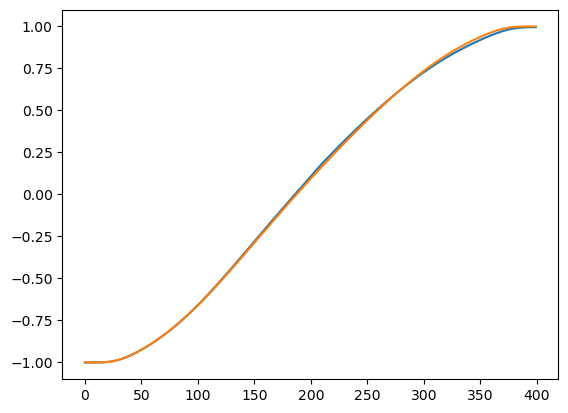

0.9956201773815888

In [18]:
#plot σz for the state that starts in |e> and goes to -i|g>
plot(xtraj[14, :])
plot(xnom[14, :])
xtraj[14, end]

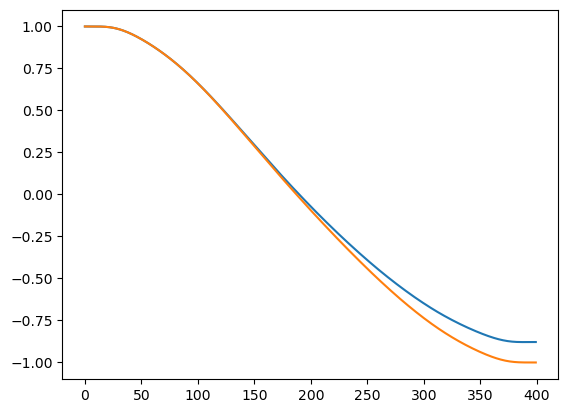

-0.8782730783994893

In [13]:
#plot σz for the state that starts in |g> and goes to -i|e>
plot(xtraj[11, :])
plot(xnom[11, :])
xtraj[11, end]

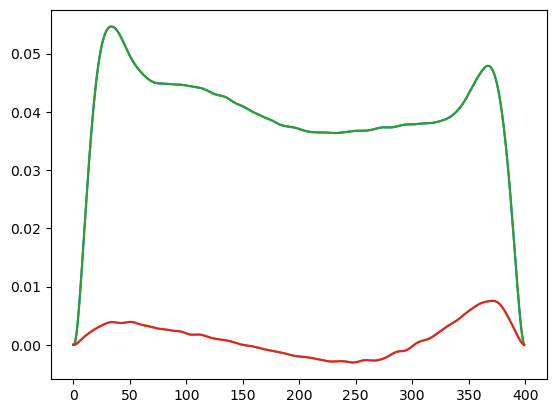

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000000006EAFBAC8>

In [14]:
# Plot controls. The blue and yellow are the nominal controls and the red and green 
#are the updated controls after each iteration.
plot([Xopt[i][15:16] for i = 1:length(Xopt)])
plot(xtraj[15,:])
plot(xtraj[16, :])

In [15]:
#Set up the ILC QP

#Costs

# Only really care about getting sigmaz measurments to be 1 since that 
# forces the other measurements to be 0.
Qf = Diagonal([fill(0., sys.isodim*sys.nqstates); [0, 0, 8000.]; [0., 0., 8000.]; fill(0., 4)])

Qilc = sparse(Diagonal([fill(0., sys.isodim*sys.nqstates); fill(1., 3*sys.nqstates); fill(0., 4)]))

Rilc = sparse(Diagonal([0.01, 0.01]))
H = blockdiag(kron(I(T-2), blockdiag(Rilc, Qilc)), Rilc, sparse(Qf))
q = zeros((n+m)*(T-1))
#errors from the "real" rollout
for k = 1:(T-2)
   q[(k-1)*(m+n) .+ (1:(m+n))] .= [zeros(sys.ncontrols); Qilc*(xtraj[:,k+1] - Xopt[k+1])] 
end
q[(T-2)*(m+n) .+ (1:(m+n))] .= [zeros(sys.ncontrols); Qf*(xtraj[:,T] - Xopt[T])]

display(xtraj[:,T] - Xopt[T])

#Constraints
U = kron(I(T-1), [I zeros(m,n)]) #Matrix that picks out all u (d2controls)
C = kron(I(T-1), [zeros(m,16) I zeros(m,2)]) #picks out all cntrls
X = kron(I(T-1), [zeros(n,m) I]) #Matrix that picks out all x
D = spzeros(n*(T-1), (n+m)*(T-1)) #dynamics constraints

D[1:n,1:m] .= B[:,:,1]
D[1:n,(m+1):(m+n)] .= -I(n)
for k = 1:(T-2)
    D[(k*n).+(1:n), (m+(k-1)*(n+m)).+(1:(2*n+m))] .= [A[:,:,k+1] B[:,:,k+1] -I]
end 

c_bnd = [fill(2π*19e-3, 2*(T-2)); zeros(2)]
ctrajF = reduce(vcat, xtraj[15:16,2:end])
lb = [zeros(n*(T-1)); -c_bnd-ctrajF]
ub = [zeros(n*(T-1)); c_bnd-ctrajF]

qp = OSQP.Model()
OSQP.setup!(qp, P=H, q=q, A=[D; C], l=lb, u=ub, eps_abs=1e-8, eps_rel=1e-8, eps_prim_inf = 1.0e-8, eps_dual_inf = 1.0e-8, polish=1)
results = OSQP.solve!(qp)
ztraj = results.x;

18-element Vector{Float64}:
 -0.05039248364419515
  0.013451946213555999
 -0.24150374405466898
  0.031002794460783578
 -0.01345194415635858
 -0.050392476726764786
  0.031002794460817995
  0.24150373487741
  0.46667715227336637
  0.10415774241360314
  0.12172692160051068
 -0.4666771339188488
 -0.10415772857874254
 -0.12172692160057963
  8.708286912753604e-13
 -1.7859054079333303e-13
 -1.734723475976807e-18
  2.168404344971009e-19

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 7980, constraints m = 7980
          nnz(P) + nnz(A) = 51360
settings: linear system solver = qdldl,
          eps_abs = 1.0e-008, eps_rel = 1.0e-008,
          eps_prim_inf = 1.0e-008, eps_dual_inf = 1.0e-008,
          rho = 1.00e-001 (adaptive),
          sigma = 1.00e-006, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter  objective    pri res    dua res    rho        time
   1 -1.0122e+002  4.47e-004  5.84e+002  1.00e-001  7.15e-002s
 200 -5.4946e+001  2.21e-005  3.68e-003  5.37e-001  5.87e-001s
 400 -3.7061e+001  1.39e-006  1.73e-0

In [16]:
#update utraj
Δu = reshape(U*ztraj, 2, :)
#display(Δu[:, 20:60])
#display(utraj[:, 20:60])
utraj = utraj+Δu
#display(utraj[:, 20:60])

2×399 Matrix{Float64}:
 0.0767016   0.0616288   0.048521    …  0.0485817   0.0572032   0.0674406
 0.00652942  0.00484291  0.00327649     0.00836932  0.00942815  0.0106061